In [1]:
import os # for detecting CPU cores
import numpy as np
import configparser # to load standard config and parameters
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from icecream import ic

warnings.filterwarnings('ignore')
%load_ext watermark
%matplotlib inline


In [2]:
# Load external config file
config = configparser.ConfigParser()
config.read("../src/config.ini")

PATH_DATA_RAW = config["PATHS"]["PATH_DATA_RAW"]
PATH_DATA_INT = config["PATHS"]["PATH_DATA_INT"]
PATH_DATA_PRO = config["PATHS"]["PATH_DATA_PRO"]
PATH_REPORTS = config["PATHS"]["PATH_REPORTS"]
PATH_MODELS = config["PATHS"]["PATH_MODELS"]
PATH_SUB = config["PATHS"]["PATH_SUB"]

# Telegram Bot
token = config["TELEGRAM"]["token"]
chat_id = config["TELEGRAM"]["chat_id"]
FILENAME_NB = "07_stacked_model" # for Telegram messages

# Set global randome state
rnd_state = 42

# Define available cpu cores
n_cpu = os.cpu_count()
print("Number of CPUs used:", n_cpu)

Number of CPUs used: 8


In [3]:
import urllib, requests #for Telegram notifications

def send_telegram_message(message):
    """Sending messages to Telegram bot via requests.get()."""
    
    message = f"{FILENAME_NB}:\n{message}"

    # Using "try and except" to ensure that the notebook execution will not be stopped only because of problems with the bot.
    # Example: No network connection.
    # ISSUE: Be careful, an error messages will leak your Telegram Bot Token when uploaded to GitHub.
    try:
        url = 'https://api.telegram.org/bot%s/sendMessage?chat_id=%s&text=%s'%(token, chat_id, urllib.parse.quote_plus(message))
        _ = requests.get(url, timeout=10)
    
    except Exception as e:
        print('\n\nSending message to Telegram Bot was not successful.\n\n')
        print(e)
        
    return None

In [4]:
train_df = pd.read_pickle(PATH_DATA_INT+'train-opt.pkl')
test_df = pd.read_pickle(PATH_DATA_INT+'test-opt.pkl')
sample_df = pd.read_csv(PATH_DATA_RAW+'sample_submission.csv')

In [5]:
train_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Columns: 102 entries, id to target
dtypes: float32(100), int32(1), int8(1)
memory usage: 231.7 MB


In [6]:
test_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540000 entries, 0 to 539999
Columns: 101 entries, id to f99
dtypes: float32(100), int32(1)
memory usage: 208.1 MB


In [7]:
features_num = train_df.drop(['id','target'], axis=1).columns
feature_cols = features_num.to_list()

X = train_df.drop(['id','target'], axis=1).copy()
y = train_df['target'].copy()
X_test = test_df.drop(['id'], axis=1).copy()

X.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
0,0.106643,3.59437,132.804001,3.18428,0.081971,1.18859,3.73238,2.266270,2.09959,0.012330,...,0.010739,1.09862,0.013331,-0.011715,0.052759,0.065400,4.211250,1.97877,0.085974,0.240496
1,0.125021,1.67336,76.533600,3.37825,0.099400,5.09366,1.27562,-0.471318,4.54594,0.037706,...,0.135838,3.46017,0.017054,0.124863,0.154064,0.606848,-0.267928,2.57786,-0.020877,0.024719
2,0.036330,1.49747,233.546005,2.19435,0.026914,3.12694,5.05687,3.849460,1.80187,0.056995,...,0.117310,4.88300,0.085222,0.032396,0.116092,-0.001689,-0.520069,2.14112,0.124464,0.148209
3,-0.014077,0.24600,779.966980,1.89064,0.006948,1.53112,2.69800,4.517330,4.50332,0.123494,...,-0.015347,3.47439,-0.017103,-0.008100,0.062013,0.041193,0.511657,1.96860,0.040017,0.044873
4,-0.003259,3.71542,156.128006,2.14772,0.018284,2.09859,4.15492,-0.038236,3.37145,0.034166,...,0.013781,1.91059,-0.042943,0.105616,0.125072,0.037509,1.043790,1.07481,-0.012819,0.072798


# Data Preprocessing

## Scaling Data

In [8]:
from sklearn.preprocessing import StandardScaler

# Scaling all values
s_scaler = StandardScaler()

"""
for col in feature_cols:
    X[col] = s_scaler.fit_transform(np.array(X[col]).reshape(-1,1))
    X_test[col] = s_scaler.transform(np.array(X_test[col]).reshape(-1,1))
"""

# train
X_scaled = s_scaler.fit_transform(X[feature_cols])
X = pd.DataFrame(X_scaled, columns=feature_cols, index=X.index)

# test
X_test_scaled = s_scaler.transform(X_test[feature_cols])
X_test = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

In [9]:
X.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
0,-0.382553,0.705771,-0.315075,0.347277,-0.229657,-0.875660,0.660314,-0.197064,-0.286162,-0.289270,...,-0.537157,-0.872508,-0.258806,-0.595537,-0.199502,-0.196145,1.067358,-0.400887,-0.167145,0.443374
1,-0.347377,-0.530387,-0.417061,0.472862,-0.187909,1.623543,-0.910506,-1.963980,1.309644,-0.229122,...,0.573313,0.658473,-0.252018,0.548089,0.019765,2.392937,-1.806811,-0.008064,-0.412110,-0.371198
2,-0.517136,-0.643571,-0.132486,-0.293650,-0.361533,0.364863,1.507175,0.824771,-0.480372,-0.183401,...,0.408845,1.580886,-0.127714,-0.226174,-0.062423,-0.516946,-1.968603,-0.294434,-0.078904,0.094984
3,-0.613619,-1.448884,0.857867,-0.490286,-0.409357,-0.656445,-0.001055,1.255833,1.281843,-0.025780,...,-0.768719,0.667692,-0.314304,-0.565262,-0.179472,-0.311897,-1.306572,-0.407556,-0.272505,-0.295118
4,-0.592913,0.783666,-0.272802,-0.323841,-0.382205,-0.293270,0.930480,-1.684456,0.543499,-0.237512,...,-0.510155,-0.346112,-0.361423,0.386926,-0.042986,-0.329511,-0.965117,-0.993613,-0.393636,-0.189697


In [10]:
X_test.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
0,-0.580494,1.506464,0.505460,-0.236312,1.282264,0.864624,-1.418770,-0.703079,1.535263,-0.184928,...,0.369787,-0.888761,-0.060378,0.225440,-0.235755,-0.458093,-1.448583,-0.453717,-0.062698,-0.419036
1,-0.570210,-1.281874,-0.737197,0.236169,-0.360850,-0.871807,1.494228,-0.034952,1.314831,-0.167090,...,-0.811922,0.115312,-0.058266,-0.220592,-0.047343,-0.481277,-1.887017,0.720929,-0.255538,-0.011450
2,2.209769,-0.038822,-0.760514,0.578383,1.376059,1.140127,-0.672360,1.373675,-0.383580,-0.305925,...,-0.730447,-0.268582,-0.283894,0.206693,-0.046161,1.879882,0.966872,0.485553,-0.114716,-0.220318
3,-0.317642,0.378388,-0.230530,-1.342777,-0.288649,-0.217623,-0.688089,-1.320170,-0.649538,-0.380502,...,-0.187612,-1.441067,-0.200515,0.590819,-0.305005,-0.421467,0.095434,-2.048174,-0.243832,-0.422770
4,-0.339998,1.738830,-0.360998,-2.036253,-0.233850,-1.343153,-1.323410,1.722561,-1.807291,-0.247371,...,-0.110000,0.140005,-0.036169,-0.191969,-0.110431,-0.239588,-0.922176,0.651969,-0.031092,-0.654751


# Feature Engineering

## KMeans Clustering

In [11]:
from sklearn.cluster import KMeans

n_clusters_1 = 9
cluster_cols = [f"cluster{i+1}" for i in range(n_clusters_1)]
#kmeans = KMeans(n_clusters=n_clusters_1, n_init=50, max_iter=500, random_state=rnd_state)
kmeans = KMeans(n_clusters=n_clusters_1, init="k-means++", max_iter=500, random_state=rnd_state)

ic(n_clusters_1);
#ic(cluster_cols);

ic| n_clusters_1: 9


In [12]:
# cluster distance instead of cluster number

# train
X_cd = kmeans.fit_transform(X[feature_cols])
X_cd = pd.DataFrame(X_cd, columns=cluster_cols, index=train_df.index)
X = X.join(X_cd)

# test
X_cd = kmeans.transform(X_test[feature_cols])
X_cd = pd.DataFrame(X_cd, columns=cluster_cols, index=test_df.index)
X_test = X_test.join(X_cd)

In [13]:
feature_cols += cluster_cols
ic(len(feature_cols));
X.head()

ic| len(feature_cols): 109


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f99,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9
0,-0.382553,0.705771,-0.315075,0.347277,-0.229657,-0.875660,0.660314,-0.197064,-0.286162,-0.289270,...,0.443374,13.524697,13.255820,13.700776,14.274755,12.859714,12.957135,36.129147,14.155721,13.117785
1,-0.347377,-0.530387,-0.417061,0.472862,-0.187909,1.623543,-0.910506,-1.963980,1.309644,-0.229122,...,-0.371198,10.190578,9.776695,10.613755,11.234726,10.152090,9.488582,35.085693,10.949151,10.154934
2,-0.517136,-0.643571,-0.132486,-0.293650,-0.361533,0.364863,1.507175,0.824771,-0.480372,-0.183401,...,0.094984,8.555463,7.960406,8.873034,9.686431,8.570634,7.778355,34.809380,9.578679,8.652315
3,-0.613619,-1.448884,0.857867,-0.490286,-0.409357,-0.656445,-0.001055,1.255833,1.281843,-0.025780,...,-0.295118,16.142962,15.755429,16.347851,16.765696,16.228905,15.869023,37.083992,16.634562,16.166245
4,-0.592913,0.783666,-0.272802,-0.323841,-0.382205,-0.293270,0.930480,-1.684456,0.543499,-0.237512,...,-0.189697,8.511881,7.657721,8.973383,9.728649,8.658378,8.013788,34.997364,9.153974,8.548635


## Polynomial Features


In [14]:
from sklearn.preprocessing import PolynomialFeatures


In [15]:
poly = PolynomialFeatures(degree=2, interaction_only=True)

X_poly = poly.fit_transform(X[cluster_cols])
T_poly = poly.transform(X_test[cluster_cols])

poly_cols = [f"cluster_poly{i+1}" for i in range(X_poly.shape[1])]

X_poly_df = pd.DataFrame(X_poly, columns=poly_cols, index=X.index)
T_poly_df = pd.DataFrame(T_poly, columns=poly_cols, index=X_test.index)

X = pd.concat([X, X_poly_df], axis=1)
X_test = pd.concat([X_test, T_poly_df], axis=1)


In [16]:
feature_cols += poly_cols
ic(len(feature_cols));
X.head()

ic| len(feature_cols): 155


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,cluster_poly37,cluster_poly38,cluster_poly39,cluster_poly40,cluster_poly41,cluster_poly42,cluster_poly43,cluster_poly44,cluster_poly45,cluster_poly46
0,-0.382553,0.705771,-0.315075,0.347277,-0.229657,-0.875660,0.660314,-0.197064,-0.286162,-0.289270,...,166.625046,464.610474,182.038513,168.690948,468.130249,183.417587,169.968903,511.434113,473.934357,185.691696
1,-0.347377,-0.530387,-0.417061,0.472862,-0.187909,1.623543,-0.910506,-1.963980,1.309644,-0.229122,...,96.328934,356.193115,111.156769,103.093803,332.913452,103.891914,96.355919,384.158569,356.292908,111.187904
2,-0.517136,-0.643571,-0.132486,-0.293650,-0.361533,0.364863,1.507175,0.824771,-0.480372,-0.183401,...,66.665428,298.338440,82.095352,74.155823,270.759705,74.506363,67.300774,333.427887,301.181732,82.877747
3,-0.613619,-1.448884,0.857867,-0.490286,-0.409357,-0.656445,-0.001055,1.255833,1.281843,-0.025780,...,257.536865,601.832581,269.960724,262.360443,588.486755,263.974243,256.542511,616.875977,599.508911,268.918396
4,-0.592913,0.783666,-0.272802,-0.323841,-0.382205,-0.293270,0.930480,-1.684456,0.543499,-0.237512,...,69.386406,303.020386,79.258560,74.017311,280.461456,73.358009,68.506958,320.364960,299.179718,78.253983


# Model Training

In [17]:
import gc
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

In [18]:
"""
transformer_num = make_pipeline(StandardScaler(),)

preprocessor = make_column_transformer((transformer_num, feature_cols))

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, stratify=y, train_size=0.75, random_state=rnd_state
)

# X_train = preprocessor.fit_transform(X_train)
# X_valid = preprocessor.transform(X_valid)
# X_test = preprocessor.transform(X_test)

input_shape = [X_train.shape[1]]
print(input_shape)
"""

'\ntransformer_num = make_pipeline(StandardScaler(),)\n\npreprocessor = make_column_transformer((transformer_num, feature_cols))\n\n# stratify - make sure classes are evenlly represented across splits\nX_train, X_valid, y_train, y_valid = train_test_split(\n    X, y, stratify=y, train_size=0.75, random_state=rnd_state\n)\n\n# X_train = preprocessor.fit_transform(X_train)\n# X_valid = preprocessor.transform(X_valid)\n# X_test = preprocessor.transform(X_test)\n\ninput_shape = [X_train.shape[1]]\nprint(input_shape)\n'

## LinearSVC

In [19]:
from sklearn.svm import LinearSVC

In [20]:
# Fold splitting parameters
splits = 10
skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)

# Two zero-filled arrays for out-of-fold (oof) and test predictions
linear_oof_preds = np.zeros((X.shape[0],))
linear_test_preds = np.zeros((X_test.shape[0],))
total_mean_auc = 0

# Generating folds and making training and prediction for each of them
for num, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    gc.collect()
    X_train, X_valid = X.loc[train_idx], X.loc[valid_idx]
    y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

    linear_model = LinearSVC(tol=1e-7, penalty='l2', dual=False, max_iter=2000, random_state=rnd_state)
    linear_model.fit(X_train, y_train)
    
    # Getting validation data predictions. Each fold model makes predictions on an unseen data.
    # So in the end it will be completely filled with unseen data predictions.
    # It will be used to evaluate hyperparameters performance only.    
    linear_oof_preds[valid_idx] = linear_model.decision_function(X_valid)
    
    # Getting mean test data predictions (i.e. devided by number of splits)
    linear_test_preds += linear_model.decision_function(X_test) / splits
    
    # Getting score for a fold model
    fold_auc = roc_auc_score(y_valid, linear_oof_preds[valid_idx])
    print(f"Fold {num} ROC AUC: {fold_auc}")
    
    # Getting mean score of all fold models (i.e. devided by number of splits)
    total_mean_auc += fold_auc / splits

    message = f'LinearSVC: Fold {num} ROC AUC: {fold_auc}'
    send_telegram_message(message)

print(f"\nOverall ROC AUC: {total_mean_auc}")

Fold 0 ROC AUC: 0.7470273786091863
Fold 1 ROC AUC: 0.7477198472135542
Fold 2 ROC AUC: 0.7447409849240512
Fold 3 ROC AUC: 0.7502203039459905
Fold 4 ROC AUC: 0.7473485013378254
Fold 5 ROC AUC: 0.75198294129877
Fold 6 ROC AUC: 0.7484955574328225
Fold 7 ROC AUC: 0.7495369548949987
Fold 8 ROC AUC: 0.7482316236593631
Fold 9 ROC AUC: 0.7527150006351085

Overall ROC AUC: 0.748801909395167


In [21]:
message = f'LinearSVC: Overall ROC AUC: {total_mean_auc}'
send_telegram_message(message)

## Neural network


In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.backend import clear_session

In [24]:
from sklearn.preprocessing import MinMaxScaler

X_nn = X.copy()
X_test_nn = X_test.copy()

# Scaling all values
mm_scaler = MinMaxScaler()
for col in X_nn.columns:
    X_nn[col] = mm_scaler.fit_transform(np.array(X_nn[col]).reshape(-1,1))
    X_test_nn[col] = mm_scaler.transform(np.array(X_test_nn[col]).reshape(-1,1))

In [25]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
class_weights_dict={}

for label in np.sort(y.unique()):
    class_weights_dict[label] = class_weights[label]

class_weights_dict

{0: 1.0121662381829593, 1: 0.9881227643722456}

In [26]:
def get_nn_model():
    """
    Builds and returns a sequential NN model along with its callbacks.
    """
    model = keras.models.Sequential()
    # An input layer
    model.add(keras.layers.Input(shape=[X_nn.shape[1],]))
    # Hidden layers
    model.add(keras.layers.Dense(64, kernel_initializer=keras.initializers.GlorotNormal, activation="swish"))
    keras.layers.Dropout(0.2),
    model.add(keras.layers.Dense(32, kernel_initializer=keras.initializers.GlorotNormal, activation="swish"))
    keras.layers.Dropout(0.2),
    model.add(keras.layers.Dense(16, kernel_initializer=keras.initializers.GlorotNormal, activation="swish"))
    keras.layers.Dropout(0.2),
    model.add(keras.layers.Dense(8, kernel_initializer=keras.initializers.GlorotNormal, activation="swish"))
    keras.layers.Dropout(0.2),
    # An output layer
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    # Checking layers setup
#     model.summary()

    # A callback to stop training when overfitting is detected
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)

    # A callback to reduce learning rate when plateau is detected
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
                monitor='val_auc', factor=0.2, patience=5, verbose=0,
                min_lr=0.00001, mode='min')

    # Compiling a model
    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['AUC', 'FalsePositives', 'FalseNegatives', 'BinaryAccuracy']
                 )
    return model, early_stopping_cb, reduce_lr

In [27]:
# Fold splitting parameters
splits = 5
skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)

# Two zero-filled arrays for out-of-fold and test predictions
nn_oof_preds = np.zeros((X_nn.shape[0],))
nn_test_preds = np.zeros((X_test_nn.shape[0],))
total_mean_auc = 0

# Generating folds and making training and prediction for each of them
for num, (train_idx, valid_idx) in enumerate(skf.split(X_nn, y)):
    clear_session()
    gc.collect()
    print(f"\n===Training with fold {num}")
    X_train, X_valid = X_nn.loc[train_idx], X_nn.loc[valid_idx]
    y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

    nn_model, early_stopping_cb, reduce_lr = get_nn_model()
    history = nn_model.fit(X_train, y_train, epochs=25,
                            validation_data=(X_valid, y_valid), 
                            callbacks=[early_stopping_cb, reduce_lr],
#                             callbacks=[early_stopping_cb],
                            class_weight=class_weights_dict
                           )
    
    # Getting validation data predictions. Each fold model makes predictions on an unseen data.
    # So in the end it will be completely filled with unseen data predictions.
    # It will be used to evaluate hyperparameters performance only.    
    nn_oof_preds[valid_idx] = nn_model.predict(X_valid).flatten()
    
    # Getting mean test data predictions (i.e. devided by number of splits)
    nn_test_preds += nn_model.predict(X_test_nn).flatten() / splits
    
    # Getting score for a fold model
    fold_auc = roc_auc_score(y_valid, nn_oof_preds[valid_idx])
    print(f"\n===Fold {num} ROC AUC: {fold_auc}")
    
    # Getting mean score of all fold models (i.e. devided by number of splits)
    total_mean_auc += fold_auc / splits

    message = f'NN: Fold {num} ROC AUC: {fold_auc}'
    send_telegram_message(message)

print(f"\nOverall ROC AUC: {total_mean_auc}")


===Training with fold 0
Epoch 1/25
15000/15000 [==============================] - 115s 8ms/step - loss: 0.6056 - auc: 0.7297 - false_positives: 73475.0000 - false_negatives: 73937.0000 - binary_accuracy: 0.6929 - val_loss: 0.5892 - val_auc: 0.7414 - val_false_positives: 17295.0000 - val_false_negatives: 16816.0000 - val_binary_accuracy: 0.7157 - lr: 0.0010
Epoch 2/25
15000/15000 [==============================] - 114s 8ms/step - loss: 0.5921 - auc: 0.7400 - false_positives: 69998.0000 - false_negatives: 68705.0000 - binary_accuracy: 0.7110 - val_loss: 0.5870 - val_auc: 0.7450 - val_false_positives: 14803.0000 - val_false_negatives: 19011.0000 - val_binary_accuracy: 0.7182 - lr: 0.0010
Epoch 3/25
15000/15000 [==============================] - 114s 8ms/step - loss: 0.5886 - auc: 0.7423 - false_positives: 69322.0000 - false_negatives: 67063.0000 - binary_accuracy: 0.7159 - val_loss: 0.6027 - val_auc: 0.7449 - val_false_positives: 12370.0000 - val_false_negatives: 24061.0000 - val_binary_

In [28]:
message = f'NN: Overall ROC AUC: {total_mean_auc}'
send_telegram_message(message)

## LightGBM


In [29]:
from lightgbm import LGBMClassifier

In [30]:
# LinearSVC and NN predictions will be used as features for LightGBM
X["linear_preds"] = linear_oof_preds
X_test["linear_preds"] = linear_test_preds
X["nn_preds"] = nn_oof_preds
X_test["nn_preds"] = nn_test_preds

In [31]:
# Model hyperparameters
lgbm_params = {'objective': 'binary',
               'boosting_type': 'gbdt',
               'num_leaves': 41,
               'max_depth': 1,
               'learning_rate': 0.15,
               'n_estimators': 40000,
               'reg_alpha': 17.6,
               'reg_lambda': 74.7,
               'random_state': rnd_state,
               'bagging_seed': rnd_state,
               'feature_fraction_seed': rnd_state,
               'n_jobs': 4,
               'subsample': 0.86,
               'subsample_freq': 4, 
               'colsample_bytree': 0.16, 
               'min_child_samples': 151, 
               'min_child_weight': 361}

In [32]:
# Setting up fold parameters
splits = 5
skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)

# Creating an array of zeros for storing "out of fold" predictions
oof_preds = np.zeros((X.shape[0],))
preds = 0
model_fi = 0
total_mean_auc = 0

# Generating folds and making training and prediction for each of 10 folds
for num, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    gc.collect()
    X_train, X_valid = X.loc[train_idx], X.loc[valid_idx]
    y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]
    
    model = LGBMClassifier(**lgbm_params)
    model.fit(X_train, y_train,
              verbose=False,
              # These three parameters will stop training before a model starts overfitting 
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              eval_metric="auc",
              early_stopping_rounds=300,
              )
    
    # Getting mean test data predictions (i.e. devided by number of splits)
    preds += model.predict_proba(X_test)[:, 1] / splits
    
    # Getting mean feature importances (i.e. devided by number of splits)
    model_fi += model.feature_importances_ / splits
    
    # Getting validation data predictions. Each fold model makes predictions on an unseen data.
    # So in the end it will be completely filled with unseen data predictions.
    # It will be used to evaluate hyperparameters performance only.
    oof_preds[valid_idx] = model.predict_proba(X_valid)[:, 1]
    
    # Getting score for a fold model
    fold_auc = roc_auc_score(y_valid, oof_preds[valid_idx])
    print(f"Fold {num} ROC AUC: {fold_auc}")

    # Getting mean score of all fold models (i.e. devided by number of splits)
    total_mean_auc += fold_auc / splits

    message = f'LGB: Fold {num} ROC AUC: {fold_auc}'
    send_telegram_message(message)
    
print(f"\nOverall ROC AUC: {total_mean_auc}")

Fold 0 ROC AUC: 0.7580085291421661
Fold 1 ROC AUC: 0.7581393516440829
Fold 2 ROC AUC: 0.7603457835868015
Fold 3 ROC AUC: 0.7587431341082161
Fold 4 ROC AUC: 0.76155060698517

Overall ROC AUC: 0.7593574810932873


In [33]:
message = f'LGB: Overall ROC AUC: {total_mean_auc}'
send_telegram_message(message)

# **Feature importances**


In [34]:
import matplotlib.pyplot as plt

In [35]:
# Creating a dataframe to be used for plotting
df = pd.DataFrame()
df["Feature"] = X.columns
# Extracting feature importances from the trained model
df["Importance"] = model_fi / model_fi.sum()
# Sorting the dataframe by feature importance
df.sort_values("Importance", axis=0, ascending=False, inplace=True)

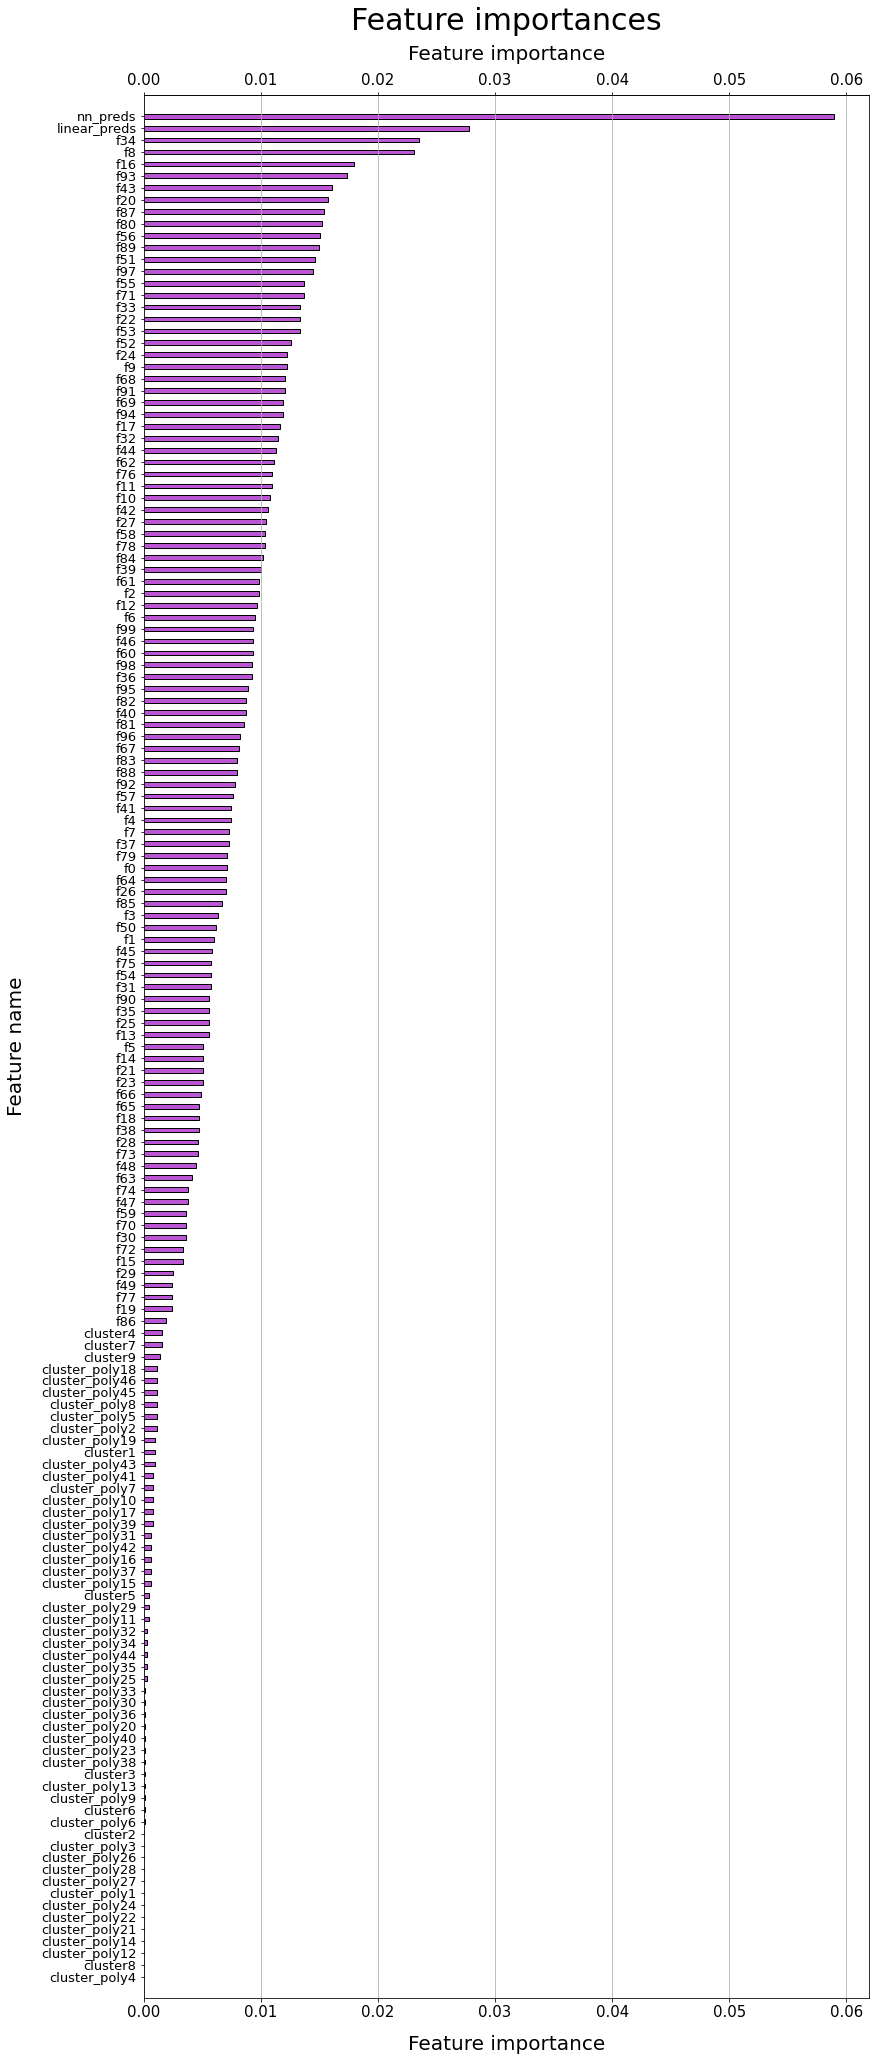

In [36]:
fig, ax = plt.subplots(figsize=(13, 35))
bars = ax.barh(df["Feature"], df["Importance"], height=0.4,
               color="mediumorchid", edgecolor="black")
ax.set_title("Feature importances", fontsize=30, pad=15)
ax.set_ylabel("Feature name", fontsize=20, labelpad=15)
ax.set_xlabel("Feature importance", fontsize=20, labelpad=15)
ax.set_yticks(df["Feature"])
ax.set_yticklabels(df["Feature"], fontsize=13)
ax.tick_params(axis="x", labelsize=15)
ax.grid(axis="x")
# Adding labels on top
ax2 = ax.secondary_xaxis('top')
ax2.set_xlabel("Feature importance", fontsize=20, labelpad=13)
ax2.tick_params(axis="x", labelsize=15)
ax.margins(0.05, 0.01)

# Inverting y axis direction so the values are decreasing
plt.gca().invert_yaxis()

# Predictions submission

In [37]:
predictions = pd.DataFrame()
predictions["id"] = test_df["id"].astype(int)
predictions["target"] = preds

predictions.to_csv('submission.csv', index=False, header=predictions.columns)
predictions.head()

,id,target
0,600000,0.748337
1,600001,0.709171
2,600002,0.745688
3,600003,0.436899
4,600004,0.693776


- Overall ROC AUC: 0.7593574810932873 | Kaggle : 0.74854

In [38]:
!kaggle competitions submit tabular-playground-series-nov-2021 -f submission.csv -m ''

Successfully submitted to Tabular Playground Series - Nov 2021



  0%|          | 0.00/14.2M [00:00<?, ?B/s]
  0%|          | 8.00k/14.2M [00:00<04:48, 51.4kB/s]
  1%|          | 112k/14.2M [00:00<00:28, 525kB/s]  
  1%|▏         | 208k/14.2M [00:00<00:21, 690kB/s]
  2%|▏         | 288k/14.2M [00:00<00:29, 499kB/s]
  2%|▏         | 352k/14.2M [00:00<00:32, 441kB/s]
  3%|▎         | 408k/14.2M [00:00<00:35, 401kB/s]
  3%|▎         | 456k/14.2M [00:01<00:37, 384kB/s]
  3%|▎         | 504k/14.2M [00:01<00:37, 383kB/s]
  4%|▍         | 544k/14.2M [00:01<01:01, 234kB/s]
  5%|▍         | 672k/14.2M [00:01<00:35, 400kB/s]
  5%|▌         | 728k/14.2M [00:01<00:36, 389kB/s]
  5%|▌         | 784k/14.2M [00:02<00:37, 377kB/s]
  6%|▌         | 832k/14.2M [00:02<00:37, 376kB/s]
  6%|▌         | 880k/14.2M [00:02<00:37, 367kB/s]
  6%|▋         | 920k/14.2M [00:02<01:21, 171kB/s]
  7%|▋         | 1.01M/14.2M [00:03<00:47, 291kB/s]
  8%|▊         | 1.06M/14.2M [00:03<00:44, 306kB/s]
  8%|▊         | 1.12M/14.2M [00:03<00:42, 321kB/s]
  8%|▊         | 1.16M/14.2M [